<a href="https://colab.research.google.com/github/DJCordhose/ml-resources/blob/main/notebooks/cv/faces-ix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge: Detecting emotions from facial expressions

<img src='https://raw.githubusercontent.com/DJCordhose/ml-resources/main/img/ai_at_work.jpeg'>

<img src='https://djcordhose.github.io/ml-resources/img/emotions.png'>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

In [2]:
import numpy as np
np.__version__

'1.22.4'

In [3]:
import pandas as pd
pd.__version__

'1.3.5'

# Part I: Train a Model

## Getting faces data

You need to download the dataset 

https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data?select=fer2013.tar.gz

from Kaggle and upload it to this notebook.

You can upload it using the `Files` view from the left menue or one of those approaches:

https://colab.research.google.com/notebooks/io.ipynb


In [5]:
!tar -xzvf fer2013.tar.gz

fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/


In [6]:
FER2013_CSV_PATH = "./fer2013/fer2013.csv"

In [7]:
df = pd.read_csv(FER2013_CSV_PATH)
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [8]:
label_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [9]:
df["emotion"].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [10]:
def plot_data(data, classes):
  
  values = data["emotion"].value_counts().sort_index(ascending=True)

  plt.bar(x=classes, height=values, edgecolor='black')

  plt.xlabel("Emotions")
  plt.ylabel("Amount")
  plt.title("Amount of emotions")
  plt.show();

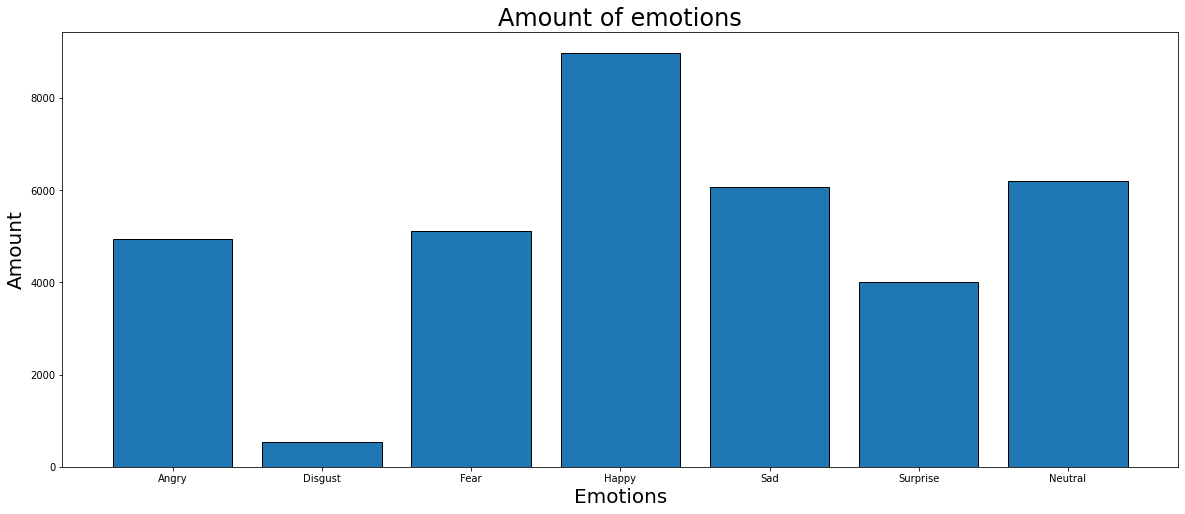

In [11]:
plot_data(df, label_names)

taking advice from 

https://github.com/joaopdss/FacialExpressionRecognition/blob/main/Facial_expression_recognition%20.ipynb

we leave out fear and disgust because they are hard to produce, plus disgust has few samples only

In [12]:
filtered_df = df[df["emotion"].isin([0, 3, 4, 5, 6, 7])]

In [13]:
# now some labels just don't have a samples, we shift all lables to the left

filtered_df["emotion"].value_counts()

3    8989
6    6198
4    6077
0    4953
5    4002
Name: emotion, dtype: int64

In [14]:
filtered_label_names = ["Angry", "Happy", "Sad", "Surprise", "Neutral"]

In [15]:
# pandas again makes this impossible to get right without stack overflow
# this does work even though we can an error
filtered_df.loc[filtered_df["emotion"] == 3, "emotion"] = 1
filtered_df.loc[filtered_df["emotion"] == 4, "emotion"] = 2
filtered_df.loc[filtered_df["emotion"] == 5, "emotion"] = 3
filtered_df.loc[filtered_df["emotion"] == 6, "emotion"] = 4

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [16]:
filtered_df["emotion"].value_counts()

1    8989
4    6198
2    6077
0    4953
3    4002
Name: emotion, dtype: int64

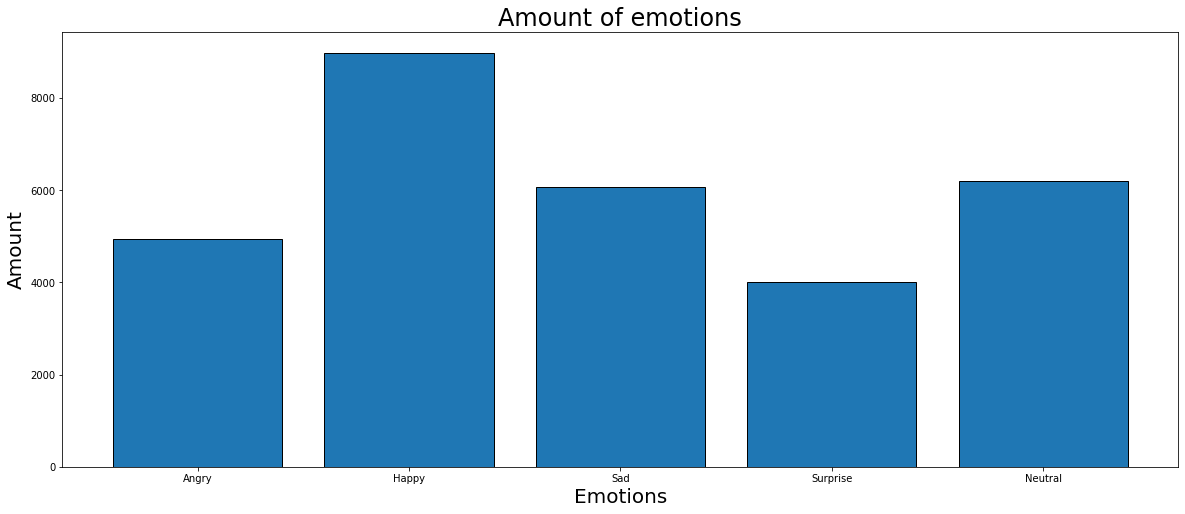

In [17]:
plot_data(filtered_df, filtered_label_names)

In [18]:
df = filtered_df

In [19]:
pixels = df["pixels"]
len(pixels)

30219

In [20]:
resolution = (48, 48)
def image_from_pixels(pixels):
    image = np.reshape(np.array(pixels.split(), 'uint8'), resolution)
    return image

In [21]:
%%time

images = np.array([image_from_pixels(p) for p in pixels])
images.shape, images.dtype

CPU times: user 7.8 s, sys: 311 ms, total: 8.11 s
Wall time: 8.18 s


((30219, 48, 48), dtype('uint8'))

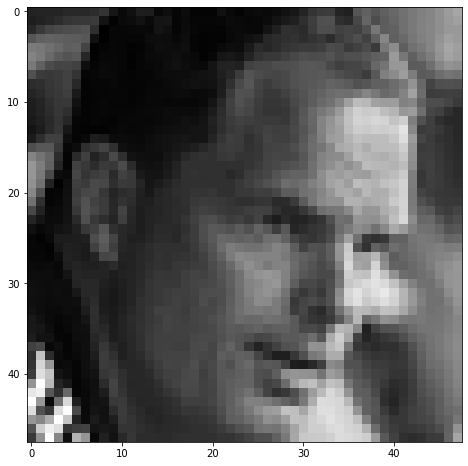

In [22]:
plt.imshow(images[100], cmap='gray');

In [23]:
labels = df["emotion"].values

In [24]:
labels.shape

(30219,)

In [25]:
def plot_gallery(X, y, label_names, size=15):

    population = X.shape[0]
    if size and size < population:
        samples = np.random.choice(population, size=size, replace=False)
    else:
        # just all
        samples = np.arange(0, population)

    for idx, i in enumerate(samples):
        ax = plt.subplot(3, 5, idx + 1)
        image = X[i]
        plt.imshow(image, cmap='gray')
        y_true = y[i]
        plt.title(label_names[y_true])
        plt.axis("off")

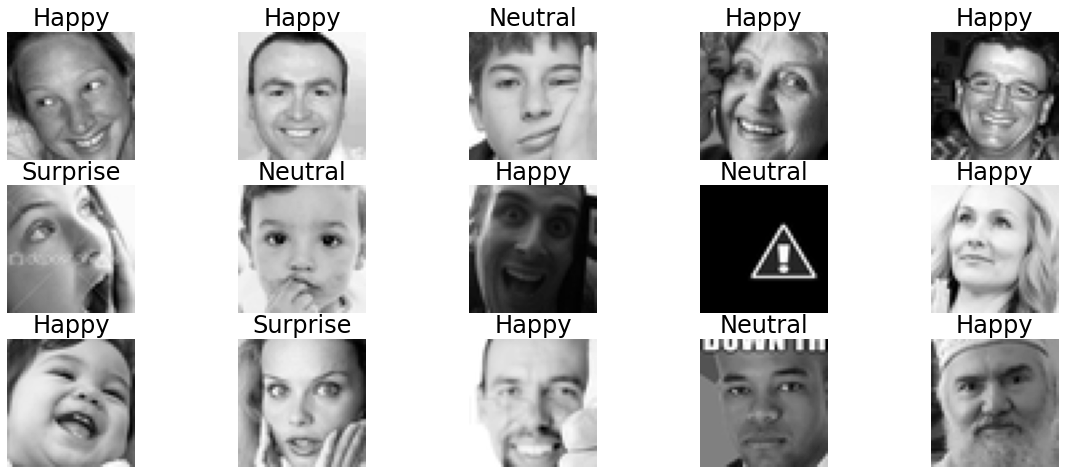

In [26]:
plot_gallery(images, labels, filtered_label_names)

## Preparing Training

In [27]:
images.shape, images.dtype

((30219, 48, 48), dtype('uint8'))

In [28]:
# images encoded as 0..255 bit maps
# neural networks can deal with bytes, but like floats close to 0 better
images.max(), images.min()

(255, 0)

In [29]:
# sometimes numpy is just great: broadcast
images_normlized = images / 255.0

# we also need to expand images, as the prebuild networks expect that
images_normlized = np.expand_dims(images_normlized, axis=-1)

In [30]:
images_normlized.shape, images_normlized.dtype, images_normlized.max(), images_normlized.min()

((30219, 48, 48, 1), dtype('float64'), 1.0, 0.0)

In [31]:
X = images_normlized
y = labels

In [32]:
np.unique(labels)

array([0, 1, 2, 3, 4])

In [33]:
num_classes = labels.max() + 1
num_classes

5

In [34]:
input_shape=(48, 48, 1)

## What kind of model should we use?

* Coming up with a decent CNN architecture is a research topic
* Using a prebuilt architecture often is the best choice
  * https://keras.io/api/applications/
  * having a lot of good training data, can make additional regularization unnecessary
  * it can be done, though, but not trivially: https://sthalles.github.io/keras-regularizer/
* however, accuracy is not the only metric we are concerned about
  * we also need this to be portable to run in the browser in the first place, plus
  * we need this to react in near real time to be useable
  * training any default architecture on CPU is simply not feasible
  * do we have a GPU availble for training 
  * which one, how powerful?
  * even on GPU this can take quite some time

In [35]:
import tensorflow as tf
tf.__version__

'2.11.0'

In [36]:
!nvidia-smi

Mon Feb 27 10:29:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [37]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Custom Model

In [38]:
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten

dropout = 0.5

model = tf.keras.Sequential(name='custom_vgg')

model.add(InputLayer(input_shape=input_shape, name='input'))

model.add(Conv2D(filters=32, kernel_size=3, activation='relu')) 
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(num_classes, activation='softmax'))

### Standard Architecture

<img src="https://djcordhose.github.io/ml-resources/img/image-recognition/cnn-architecture-overview.jpeg">

https://towardsdatascience.com/neural-network-architectures-156e5bad51ba 
<br>
https://arxiv.org/abs/1605.07678

In [39]:
use_custom_model = True
# use_custom_model = False

In [40]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

if not use_custom_model:
  # model = ResNet50(weights='imagenet')
  model = ResNet50(weights=None, input_shape=input_shape, classes=num_classes)

In [41]:
model.summary()

Model: "custom_vgg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 23, 23, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0

In [42]:
# https://github.com/AndreasMadsen/python-lrcurve
import sys

if 'google.colab' in sys.modules:
  !pip install -q lrcurve

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.0/71.0 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.7 MB/s eta 0:00:00


In [43]:
# we play be our own rules, we do our own split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=21, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((27197, 48, 48, 1), (3022, 48, 48, 1), (27197,), (3022,))

### Training

In [44]:
if use_custom_model:
  optimizer='adam'
else:  
  # optimizer='adam'
  optimizer='sgd'
optimizer  

'adam'

In [45]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

In [46]:
# ReduceLROnPlateau inspired by https://github.com/joaopdss/FacialExpressionRecognition/blob/main/Facial_expression_recognition%20.ipynb

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_lr = ReduceLROnPlateau()

if use_custom_model:
  patience = 10
else:
  patience=15
early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience)

In [47]:
%%time

from lrcurve import KerasLearningCurve

if use_custom_model:
  BATCH_SIZE = 50
else:
  # larger batch size might lead to better regularization for resent
  # (might speed up learning on a good GPU)
  BATCH_SIZE = 50

# Resnet50 75 epochs
# - 30 min on T4
# - 18 min on A100
# - < 15 min on V100

EPOCHS = 75
# should be enough for resnet
# EPOCHS = 50

history = model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    shuffle=True,
                    validation_data=(X_test, y_test),
                    # validation_split=0.1,
                    callbacks=[reduce_lr, early_stopping, KerasLearningCurve()],
                    verbose=0
                    )

CPU times: user 3min 20s, sys: 9.07 s, total: 3min 29s
Wall time: 3min 17s


## Evaluating results

In [48]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
print(f'Training accuracy: {round(train_accuracy, 2)}, Test accuracy: {round(test_accuracy, 2)}')

Training accuracy: 0.68, Test accuracy: 0.65


In [93]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_cm(model, X, y, file_name=None, label_names=label_names, percent=True):
    y_pred = model.predict(X).argmax(axis=1)
    figure = plt.figure(figsize=(15, 15))

    if percent:
      cm = confusion_matrix(y, y_pred, normalize='pred')
      gfg = sns.heatmap(cm, annot=True, xticklabels=label_names, yticklabels=label_names, cmap='Blues', vmin=0, vmax=1)
    else:
      cm = confusion_matrix(y, y_pred)
      gfg = sns.heatmap(cm, annot=True, xticklabels=label_names, yticklabels=label_names, cmap='Blues', fmt='d')
    gfg.set(xlabel ="Prediction", ylabel = "Truth")

    if file_name:
        plt.savefig('%s.png' % file_name)

In [ ]:
# normalize prediction
def plot_cm(model, X, y, file_name=None, label_names=label_names):
    y_pred = model.predict(X).argmax(axis=1)
    cm = confusion_matrix(y, y_pred, normalize='pred')
    figure = plt.figure(figsize=(8, 8))

    if file_name:
        plt.savefig('%s.png' % file_name)

In [50]:
def plot_accuracy(history, file_name=None):
    plt.figure()
    plt.xlabel('epochs')
    plt.ylabel('accuracy')

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['Accuracy', 'Validation Accuracy']);
    if file_name:
        plt.savefig('%s.png' % file_name)

In [51]:
def plot_loss(history, file_name=None):
    plt.figure()

    plt.xlabel('epochs')
    plt.ylabel('loss')

    plt.yscale('log')

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['Loss', 'Validation Loss']);
    if file_name:
        plt.savefig('%s.png' % file_name)

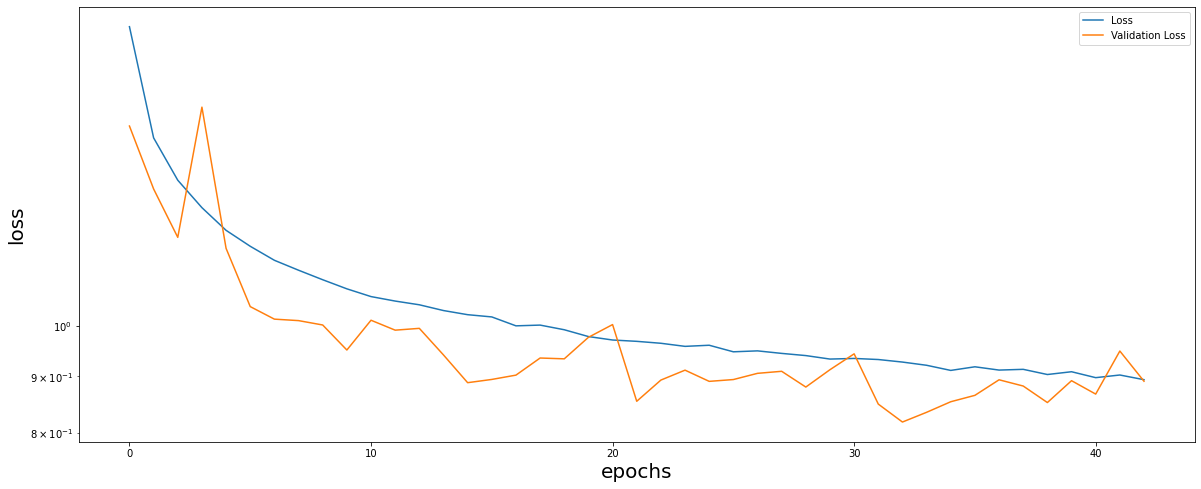

In [52]:
plot_loss(history)

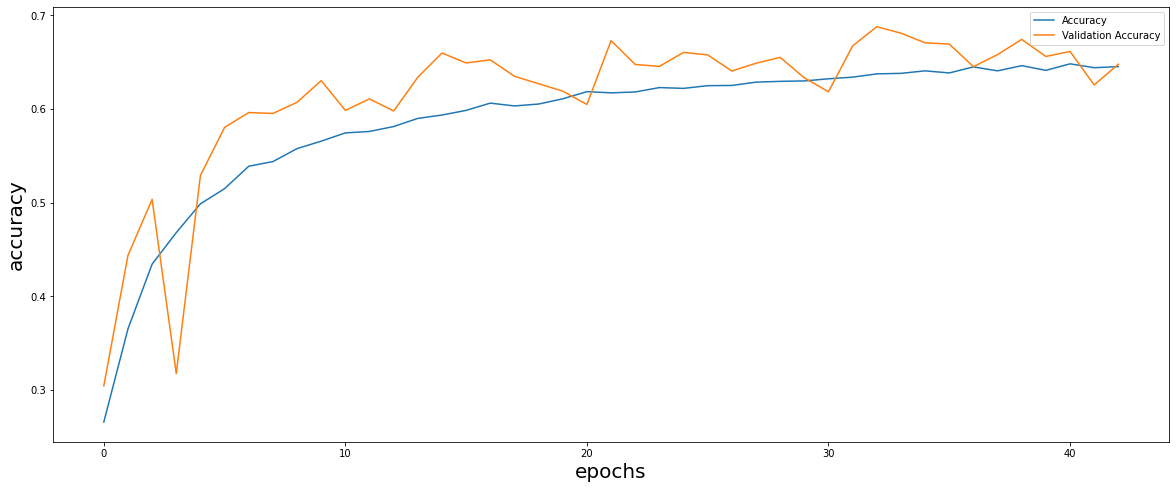

In [53]:
plot_accuracy(history)

945/945 [==============================] - 4s 5ms/step


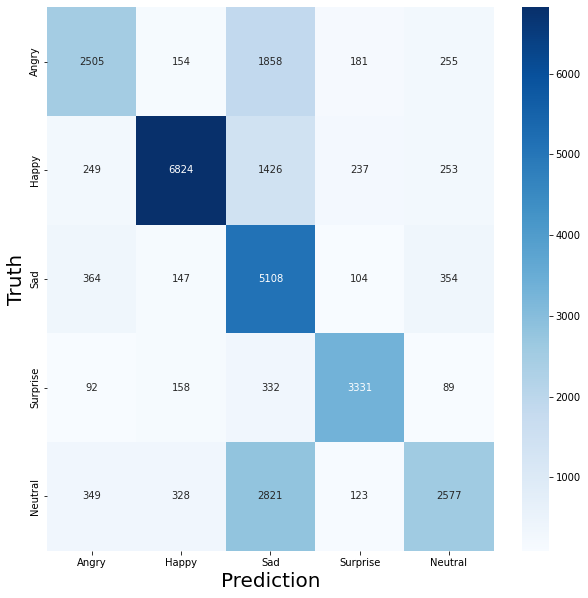

In [86]:
plot_cm(model, X, y, label_names=filtered_label_names, percent=False)

850/850 [==============================] - 2s 2ms/step


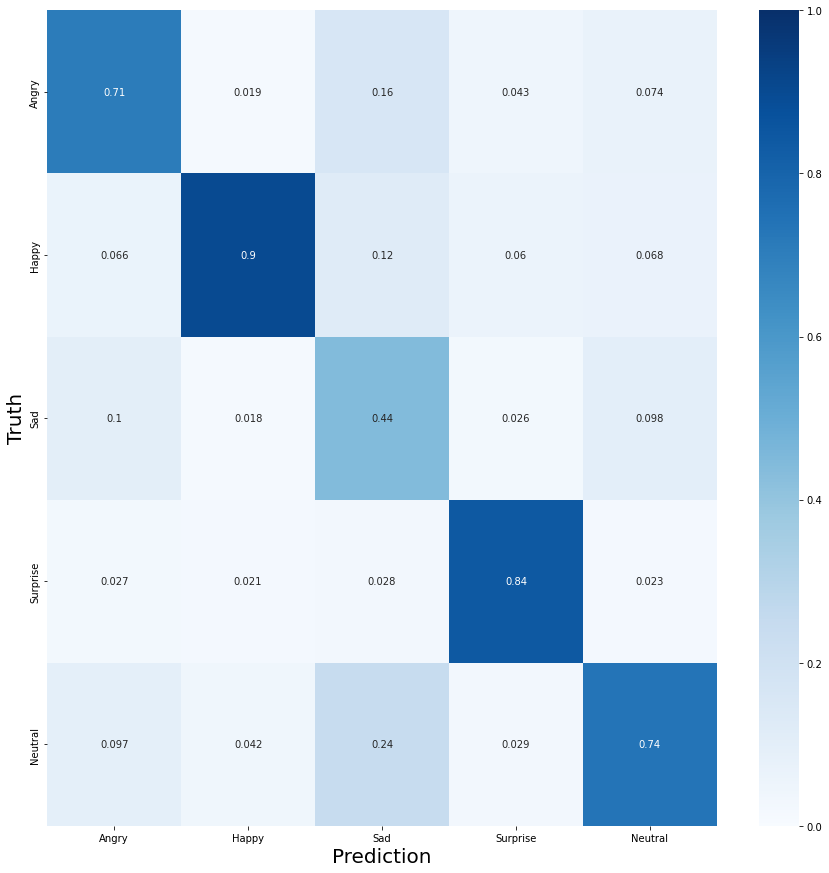

In [94]:
plot_cm(model, X_train, y_train, label_names=filtered_label_names, file_name='cm_train')

95/95 [==============================] - 1s 6ms/step


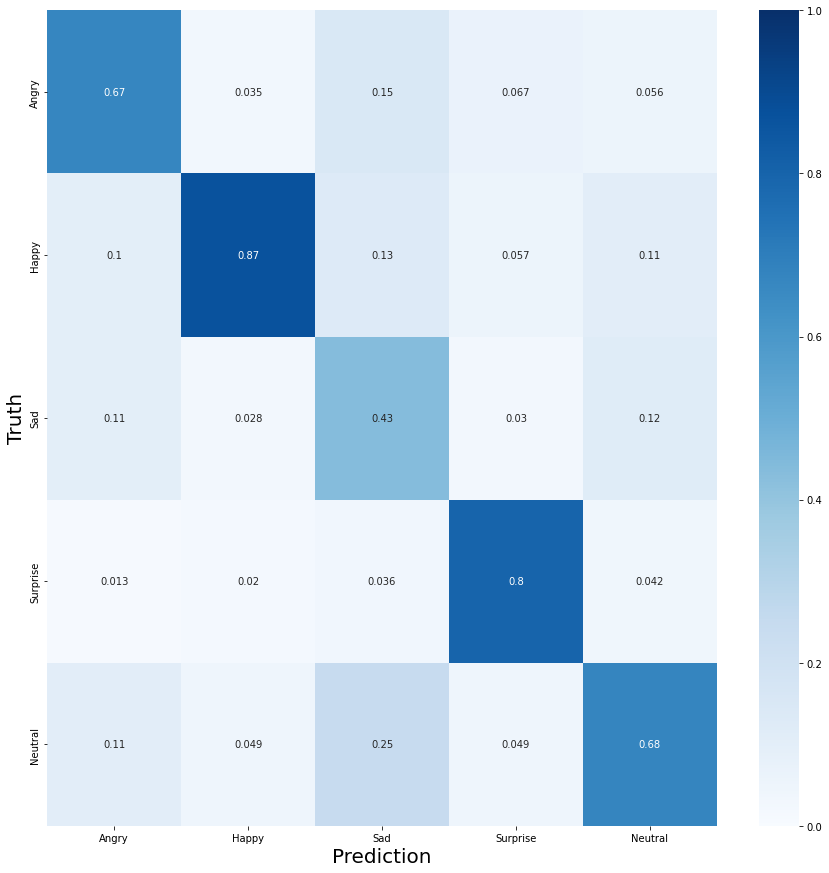

In [95]:
plot_cm(model, X_test, y_test, label_names=filtered_label_names, file_name='cm_test')

## Saving model

You might also want to download it for later use

In [57]:
if use_custom_model:
  model_name = 'mlcon-simple-vgg.h5'
else:
  model_name = 'mlcon-resent50.h5'
model.save(model_name)

In [58]:
!ls -l

total 98828
drwxr-x--- 2 204241 5762     4096 Jul 10  2013 fer2013
-rw-r--r-- 1 root   root 96433867 Feb 27 10:27 fer2013.tar.gz
-rw-r--r-- 1 root   root  4750192 Feb 27 10:37 mlcon-simple-vgg.h5
drwxr-xr-x 1 root   root     4096 Feb 23 14:38 sample_data


# Part II: Preprocessing

## Challenge of our model

* Data for training comes from completely different source than for prediction
* Not uncommon
* Typically the case when having to rely on general / public dataset
* Often means test score is well below validation score
* Might need an extra round of training with small set of data from prediction source


In [59]:
!wget -c https://github.com/DJCordhose/ml-resources/raw/main/data/emotions.zip

--2023-02-27 10:37:22--  https://github.com/DJCordhose/ml-resources/raw/main/data/emotions.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/DJCordhose/ml-resources/main/data/emotions.zip [following]
--2023-02-27 10:37:22--  https://media.githubusercontent.com/media/DJCordhose/ml-resources/main/data/emotions.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31806281 (30M) [application/zip]
Saving to: ‘emotions.zip’

emotions.zip        100%[===================>]  30.33M   164MB/s    in 0.2s    

2023-02-27 10:37:23 (164 MB/s) - ‘emotions.zip’ saved [31806281/31806281]



In [60]:
!unzip -o emotions.zip

Archive:  emotions.zip
   creating: emotions/angry/
  inflating: emotions/angry/IMG-20221120-WA0013.jpg  
  inflating: emotions/angry/leonie-angry.jpg  
  inflating: emotions/angry/olli-angry.jpg  
  inflating: emotions/angry/olli-zopf-angry.jpg  
  inflating: emotions/angry/olli-zopf-brille-angry.jpg  
  inflating: emotions/angry/tim-angry.jpg  
   creating: emotions/happy/
  inflating: emotions/happy/IMG-20221120-WA0011.jpg  
  inflating: emotions/happy/leonie-happy.jpg  
  inflating: emotions/happy/olli-happy.jpg  
  inflating: emotions/happy/olli-zopf-brille-happy.jpg  
  inflating: emotions/happy/olli-zopf-happy.jpg  
  inflating: emotions/happy/tim-happy.jpg  
   creating: emotions/neutral/
  inflating: emotions/neutral/IMG-20221120-WA0010.jpg  
  inflating: emotions/neutral/leonie-neutral.jpg  
  inflating: emotions/neutral/olli-neutral.jpg  
  inflating: emotions/neutral/olli-zopf-brille-neutral.jpg  
  inflating: emotions/neutral/olli-zopf-neutral.jpg  
  inflating: emotions/n

In [61]:
import cv2 as cv
cv.__version__

'4.6.0'

In [62]:
# Leonie
# img = cv.imread('emotions/happy/leonie-happy.jpg')
# img = cv.imread('emotions/neutral/leonie-neutral.jpg')
# img = cv.imread('emotions/sad/leonie-sad.jpg')
# img = cv.imread('emotions/surprise/leonie-surprise.jpg')
# img = cv.imread('emotions/angry/leonie-angry.jpg')

# Tim
# img = cv.imread('emotions/happy/tim-happy.jpg')
# img = cv.imread('emotions/neutral/tim-neutral.jpg')
# img = cv.imread('emotions/sad/tim-sad.jpg')
# img = cv.imread('emotions/surprise/tim-surprise.jpg')
# img = cv.imread('emotions/angry/tim-angry.jpg')

# Olli
# img = cv.imread('emotions/happy/olli-happy.jpg')
# img = cv.imread('emotions/neutral/olli-neutral.jpg')
# img = cv.imread('emotions/sad/olli-sad.jpg')
# img = cv.imread('emotions/surprise/olli-surprise.jpg')
# img = cv.imread('emotions/angry/olli-angry.jpg')

# Hanna
# img = cv.imread('emotions/sad/IMG-20221120-WA0012.jpg')
img = cv.imread('emotions/surprise/IMG-20221120-WA0014.jpg') 

img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_rgb.shape

(2048, 1153, 3)

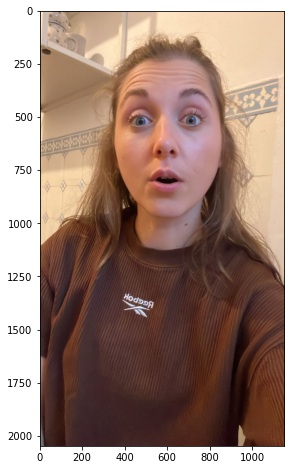

In [63]:
plt.imshow(img_rgb);

## OpenCV Processing

### Overview: Common Methods used with OpenCV

* Convolutions (Blur/Sobel/Sharpen): https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html
* Edge-Detection: https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html
* Morphological Operations (Opening/Closing): https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html
* Contours and Bounding Boxes: https://docs.opencv.org/4.x/d3/d05/tutorial_py_table_of_contents_contours.html
* Segmentation: https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html
* Template Matching: https://docs.opencv.org/4.x/d4/dc6/tutorial_py_template_matching.html

https://docs.opencv.org/4.x/d2/d96/tutorial_py_table_of_contents_imgproc.html


### Obvously when using in prodcution, we do not have the faces nicely cut out so far

* can be done
  * also based on ML, but ML other people have already done for us
  * requires a good set of bounding boxes as training data
  * advanced techniques like SSD (https://towardsdatascience.com/ssd-single-shot-detector-for-object-detection-using-multibox-1818603644ca) require a lot of compute to train

* Approaches
  * https://docs.opencv.org/4.x/db/d28/tutorial_cascade_classifier.html
  * https://pyimagesearch.com/2018/02/26/face-detection-with-opencv-and-deep-learning/
  * https://pyimagesearch.com/2021/04/26/face-detection-tips-suggestions-and-best-practices/
  * https://pyimagesearch.com/2022/10/24/thermal-vision-fever-detector-with-python-and-opencv-starter-project/

#### Our approach: Cascade Classifier

* OpenCV implementation available 
* error prone, but fast
* works in browser
* fast and small model
* alternatives: https://pyimagesearch.com/2021/04/26/face-detection-tips-suggestions-and-best-practices/

https://docs.opencv.org/4.x/db/d28/tutorial_cascade_classifier.html



### Grayscale

needed by facial extraction

((2048, 1153), 254)

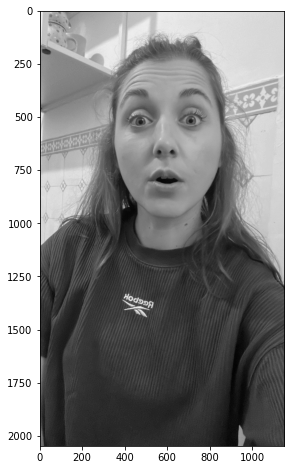

In [64]:
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap='gray')
img_gray.shape, img_gray.max()

### Histogram Equalization (might make it easier for face extraction)

normalizes the brightness and increases the contrast of the image

* flattens the gray-level histogram 
* all intensities are as equally common as possible

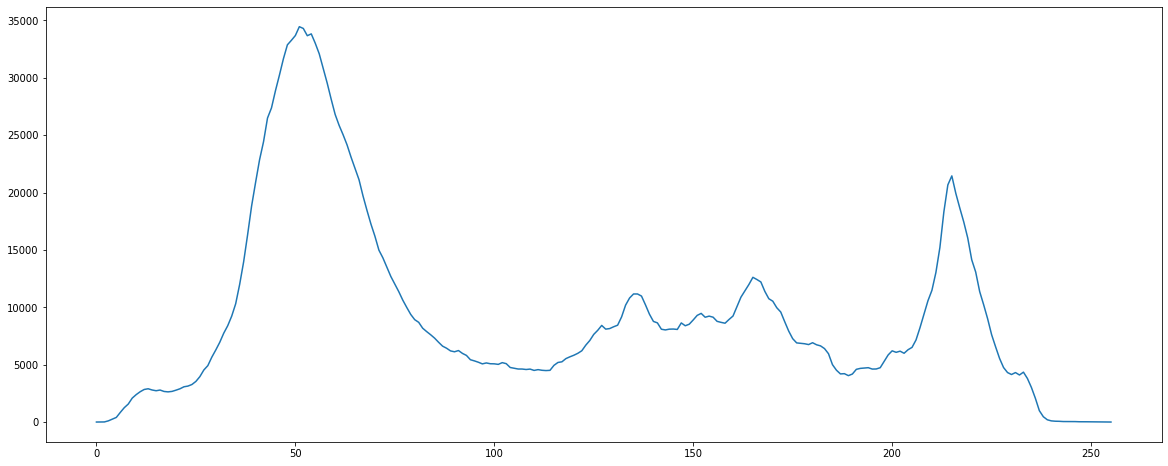

In [65]:
histr = cv.calcHist([img_gray],[0],None,[256],[0,256])
plt.plot(histr);

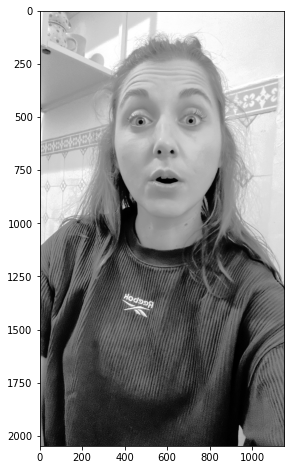

In [66]:
img_gray = cv.equalizeHist(img_gray)
plt.imshow(img_gray, cmap='gray');

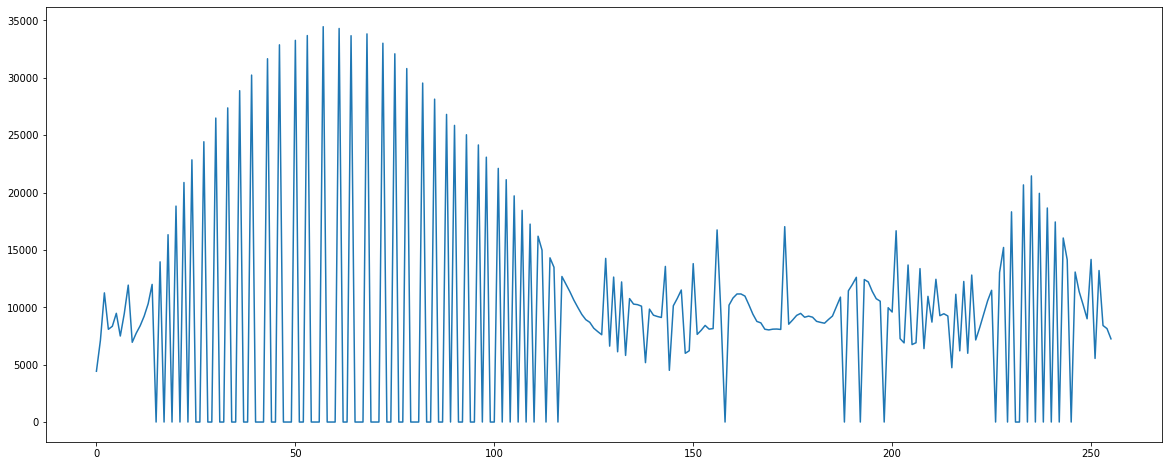

In [67]:
histr = cv.calcHist([img_gray],[0],None,[256],[0,256])
plt.plot(histr);

### Extraction of Region Of Interest (ROI)

In [68]:
img_height, img_width = img_gray.shape
img_height, img_width

(2048, 1153)

In [69]:
min_face_height = round(img_height * .1)
min_face_width = round(img_width * .1)
min_face_height, min_face_width

(205, 115)

In [70]:
faceCascade = cv.CascadeClassifier(cv.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(
        img_gray,
        minSize=(min_face_height, min_face_width)
) 
faces

array([[218, 222, 733, 733]], dtype=int32)

In [71]:
# we assume a single face
largest_index = faces[:, 3].argmax()
face = faces[largest_index]
fx, fy, fw, fh = face
face

array([218, 222, 733, 733], dtype=int32)

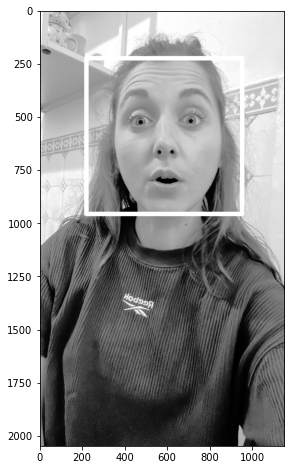

In [72]:
color = (255, 0, 255)
thickness = 20

frame_gray = img_gray.copy()

center = (fx + fw//2, fy + fh//2)
# frame = cv.ellipse(frame, center, (w//2, h//2), 0, 0, 360, color, thickness)
pt1 = (fx, fy)
pt2 = (fx + fw, fy + fh)
cv.rectangle(frame_gray, pt1, pt2, color, thickness)
plt.imshow(frame_gray, cmap='gray');    

(733, 733)

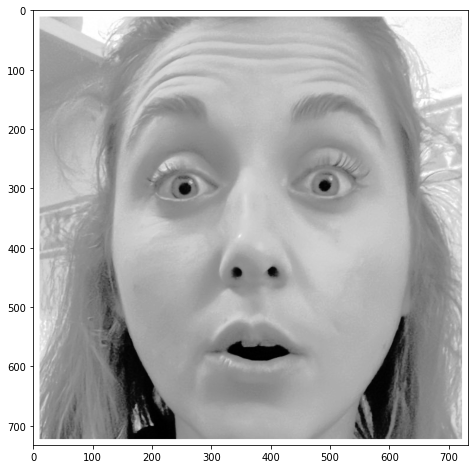

In [73]:
roi = frame_gray[fy:fy+fh,fx:fx+fw]
plt.imshow(roi, cmap='gray');
roi.shape

### Resizing and normalizing

In [74]:
roi = cv.resize(roi, (48, 48), 0, 0, cv.INTER_AREA);
# roi = cv.normalize(roi, 0, 1.0, cv.NORM_MINMAX);
roi = roi / 255.0

((48, 48), 0.0, 1.0)

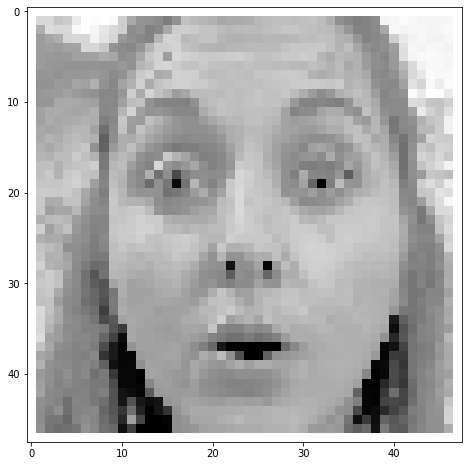

In [75]:
plt.imshow(roi, cmap='gray');
roi.shape, roi.min(), roi.max()

(0.0, 1.0, dtype('float64'))

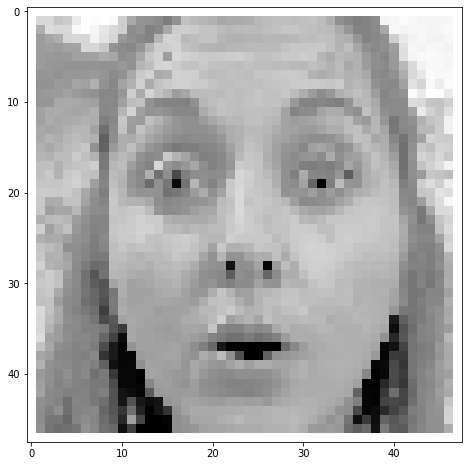

In [76]:
test_img = roi

# normalization (might not be necessary for most transformations, but just to make sure)
test_img = (test_img - test_img.min()) / (test_img.max() + abs(test_img.min()))

plt.imshow(test_img, cmap='gray');
test_img.min(), test_img.max(), test_img.dtype

### Preparation for prediction

In [77]:
test_img = np.expand_dims(test_img, axis=-1)
test_img = np.expand_dims(test_img, axis=0)
test_img.shape

(1, 48, 48, 1)

In [78]:
# you can load a predefined model

# !wget -c https://github.com/DJCordhose/ml-resources/raw/main/data/tmp/simple-vgg.h5
# !wget -c https://github.com/DJCordhose/ml-resources/raw/main/data/tmp/resent50.h5

In [79]:
import tensorflow as tf
# model = tf.keras.models.load_model('simple-vgg.h5')
# model = tf.keras.models.load_model('resent50.h5')

In [80]:
filtered_label_names = ["Angry", "Happy", "Sad", "Surprise", "Neutral"]

In [81]:
y_pred_probas = model.predict(test_img)
clazz = y_pred_probas.argmax()
proba = y_pred_probas.max()
filtered_label_names[clazz], proba, y_pred_probas

1/1 [==============================] - 0s 89ms/step


('Surprise',
 0.9950589,
 array([[1.7522349e-03, 9.4395404e-04, 1.0238435e-03, 9.9505889e-01,
         1.2210694e-03]], dtype=float32))

# Part III: Integration, ML as a system

## Complete pipeline

In [96]:
def preprocess(path):
  img = cv.imread(path)
  img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  img_gray = cv.equalizeHist(img_gray)
  # add whatever processing you have here

  face = detect_face(img_gray)
  if face is None:
    return None
  x, y, w, h = face
  frame_gray = img_gray.copy()
  roi = frame_gray[y:y+h,x:x+w]
  roi = cv.resize(roi, (48, 48), 0, 0, cv.INTER_AREA);
  # roi = cv.normalize(roi, 0, 1.0, cv.NORM_MINMAX);
  roi = roi / 255.0
  test_img = np.expand_dims(roi, axis=-1)
  # test_img = np.expand_dims(test_img, axis=0)
  return test_img

def detect_face(img_gray):
  img_height, img_width = img_gray.shape
  min_face_height = round(img_height * .1)
  min_face_width = round(img_width * .1)
  faceCascade = cv.CascadeClassifier(cv.data.haarcascades + "haarcascade_frontalface_default.xml")
  faces = faceCascade.detectMultiScale(
          img_gray,
          minSize=(min_face_height, min_face_width)
  ) 
  if faces is None:
    return None

  # we assume a single face
  largest_index = faces[:, 3].argmax()
  face = faces[largest_index]
  return face

def predict(test_img):
  y_pred_probas = model.predict(test_img)
  clazz = y_pred_probas.argmax()
  proba = y_pred_probas.max()
  return filtered_label_names[clazz], proba, y_pred_probas

(48, 48, 1)

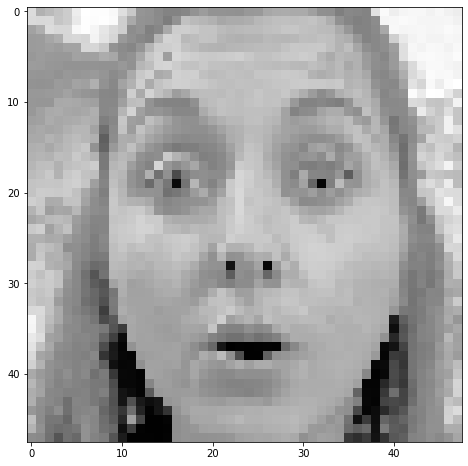

In [97]:
img = preprocess('emotions/surprise/IMG-20221120-WA0014.jpg')
plt.imshow(img.reshape(48, 48), cmap='gray');
img.shape

In [98]:
predict(np.expand_dims(img, axis=0))

1/1 [==============================] - 0s 19ms/step


('Surprise',
 0.99496293,
 array([[1.7669318e-03, 9.8807097e-04, 1.0541830e-03, 9.9496293e-01,
         1.2277918e-03]], dtype=float32))

## Evaluation on real world data

In [99]:
!ls -lR emotions

emotions:
total 20
drwxr-xr-x 2 root root 4096 Nov 26 11:40 angry
drwxr-xr-x 2 root root 4096 Nov 26 11:40 happy
drwxr-xr-x 2 root root 4096 Nov 26 11:41 neutral
drwxr-xr-x 2 root root 4096 Nov 26 11:41 sad
drwxr-xr-x 2 root root 4096 Nov 26 11:42 surprise

emotions/angry:
total 6336
-rw-r--r-- 1 root root  264780 Nov 21 15:45 IMG-20221120-WA0013.jpg
-rw-r--r-- 1 root root  173760 Oct 28 17:02 leonie-angry.jpg
-rw-r--r-- 1 root root 2139114 Oct 28 17:06 olli-angry.jpg
-rw-r--r-- 1 root root 1859338 Nov 18 11:05 olli-zopf-angry.jpg
-rw-r--r-- 1 root root 1846678 Nov 18 11:05 olli-zopf-brille-angry.jpg
-rw-r--r-- 1 root root  194744 Oct 28 16:53 tim-angry.jpg

emotions/happy:
total 6244
-rw-r--r-- 1 root root  284105 Nov 21 15:45 IMG-20221120-WA0011.jpg
-rw-r--r-- 1 root root  190881 Oct 28 17:03 leonie-happy.jpg
-rw-r--r-- 1 root root 1913455 Oct 28 17:06 olli-happy.jpg
-rw-r--r-- 1 root root 1886990 Nov 18 11:05 olli-zopf-brille-happy.jpg
-rw-r--r-- 1 root root 1917482 Nov 18 11:05 oll

In [100]:
%%time 

import os
data_dir = 'emotions'
type = ".jpg"

# Get all subdirectories of data_dir. Each represents a label.
directories = [d for d in os.listdir(data_dir) 
                if os.path.isdir(os.path.join(data_dir, d))]
# Loop through the label directories and collect the data in
# two lists, labels and images.
labels = []
images = []
for d in directories:
    label_dir = os.path.join(data_dir, d)
    file_names = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(type)]
    # For each label, load it's images and add them to the images list.
    # And add the label number (i.e. directory name) to the labels list.
    for f in file_names:
      img = preprocess(f)
      images.append(img)
      label = filtered_label_names.index(d.title())
      labels.append(label)

images, labels = np.array(images), np.array(labels)

CPU times: user 6.47 s, sys: 340 ms, total: 6.81 s
Wall time: 5.28 s


In [101]:
images.shape, labels

((30, 48, 48, 1),
 array([2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3,
        3, 3, 1, 1, 1, 1, 1, 1]))

In [102]:
X_real_world = images
y_real_world = labels

### Current Model

In [103]:
local_model = model

In [104]:
model.name

'custom_vgg'

In [105]:
_, real_world_accuracy = model.evaluate(X_real_world, y_real_world, verbose=0)
real_world_accuracy

0.6666666865348816

1/1 [==============================] - 0s 23ms/step


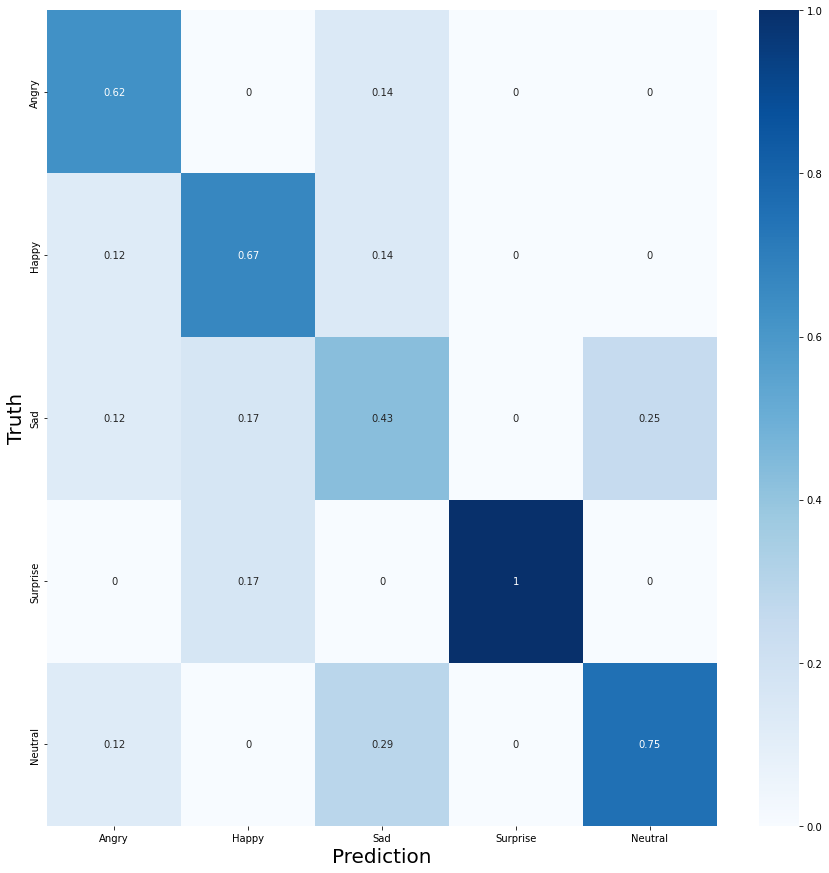

In [107]:
plot_cm(model, X_real_world, y_real_world, label_names=filtered_label_names);

1/1 [==============================] - 0s 58ms/step


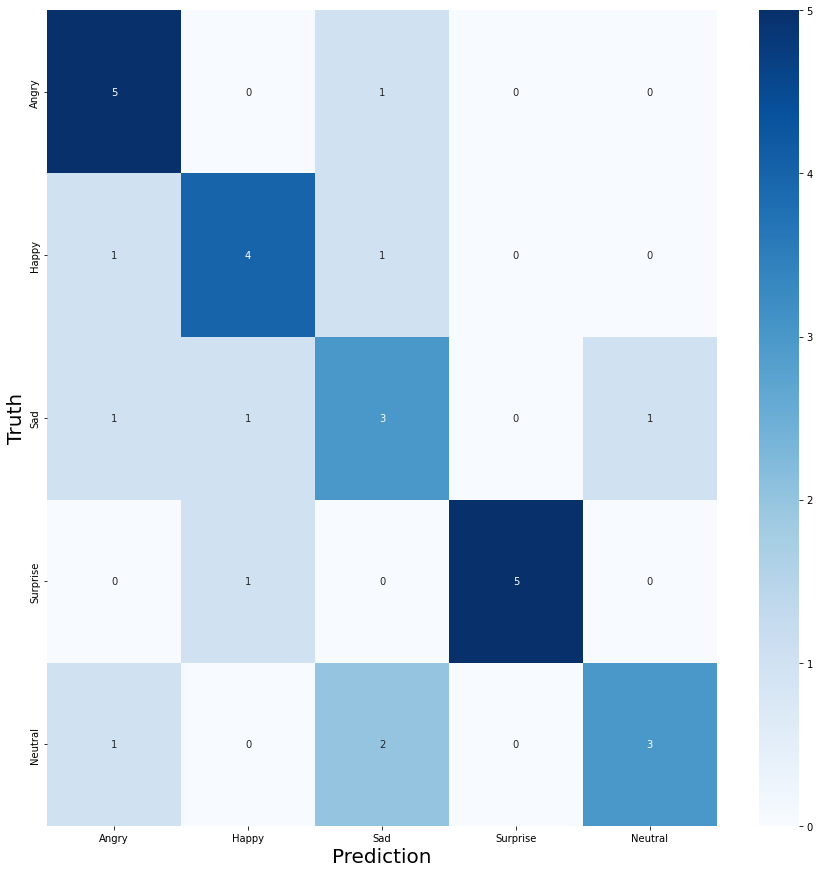

In [110]:
plot_cm(model, X_real_world, y_real_world, label_names=filtered_label_names, percent=False, file_name='cm_val');

## Looking at subclasses

In [111]:
def plot_gallery(model, X, y, label_names, size=15):
    figure = plt.figure(figsize=(40, 20))

    y_pred_raw = model.predict(X, verbose=0)
    certainty = y_pred_raw.max(axis=1)
    y_pred = y_pred_raw.argmax(axis=1)
    population = X.shape[0]

    if size and size < population:
        samples = np.random.choice(population, size=size, replace=False)
    else:
        # just all
        samples = np.arange(0, population)

    for idx, i in enumerate(samples):
        ax = plt.subplot(3, 5, idx + 1)
        image = X[i]
        plt.imshow(image.reshape(48, 48), cmap='gray')
        y_true = y[i]
        y_pred = model.predict(tf.expand_dims(image, 0), verbose=0).argmax(axis=1)[0]
        plt.title("{} (was {}): {} ({:3d}%)".format(label_names[y_pred],
                                                  label_names[y_true],
                                                  i,
                                                  int(certainty[i] * 100)),
                  color=("green" if y_pred == y_true else "red"))
        plt.axis("off")
    return certainty.max(), certainty.min(), certainty.mean()

In [112]:
# which model do we want?

model = local_model
# model = resent50_model
# model = simple_vgg_model
model.name

'custom_vgg'

In [113]:
y_real_world_pred_raw = model.predict(X_real_world, verbose=0)
y_real_world_pred = y_real_world_pred_raw.argmax(axis=1)
y_real_world_pred

array([2, 2, 1, 2, 4, 0, 4, 0, 2, 2, 4, 4, 0, 2, 0, 0, 0, 0, 3, 3, 3, 3,
       3, 1, 1, 0, 1, 1, 1, 2])

### All

(0.99496293, 0.3462912, 0.62003076)

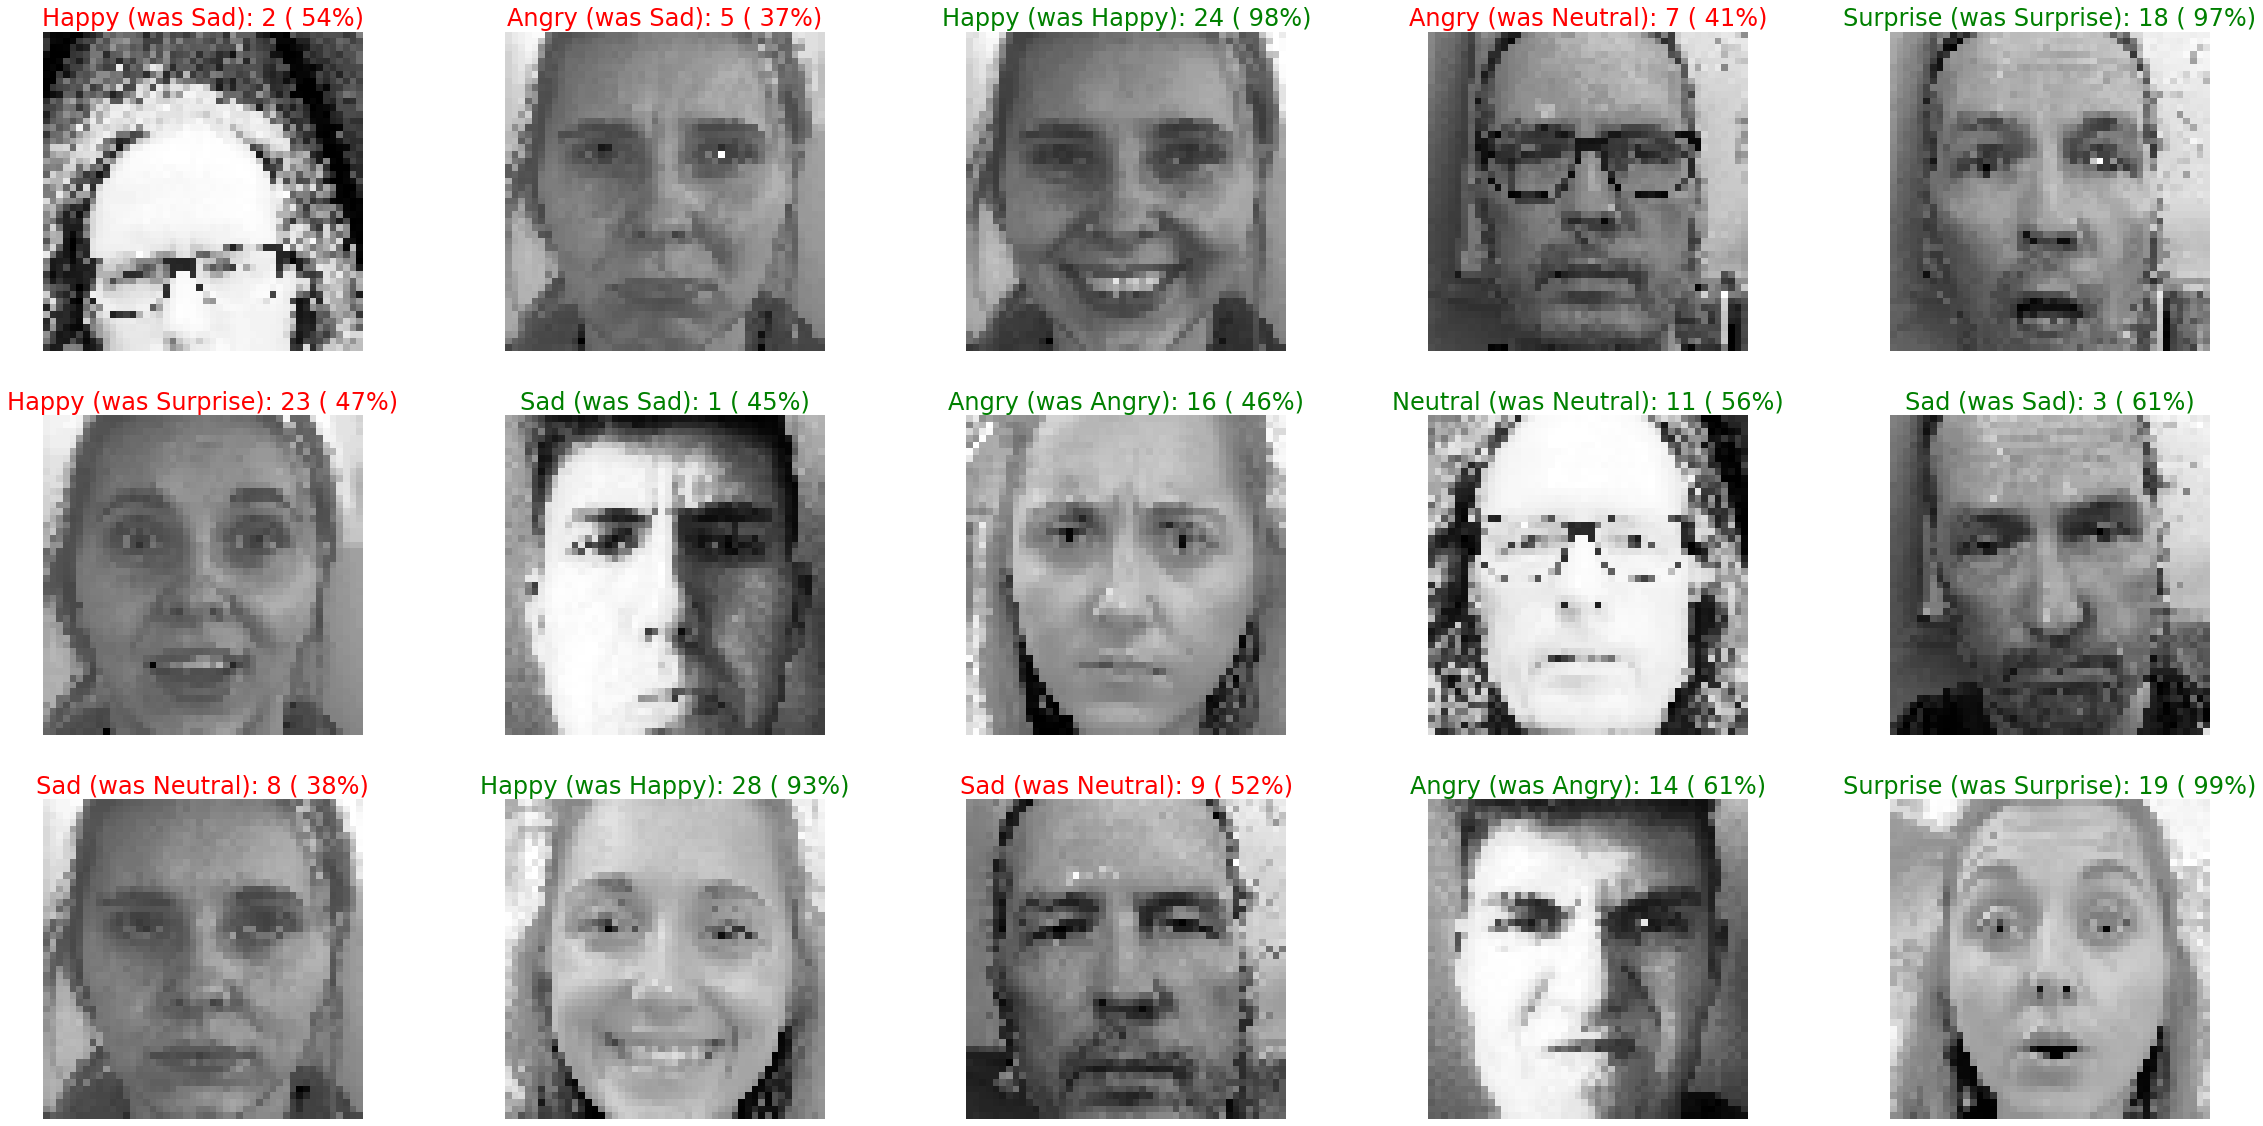

In [114]:
plot_gallery(model, X_real_world, y_real_world, filtered_label_names)

### Wrong

In [115]:
wrong_indices = np.where(y_real_world_pred != y_real_world)[0]
wrong_indices

array([ 2,  4,  5,  7,  8,  9, 13, 23, 25, 29])

(0.54337317, 0.37312543, 0.4355845)

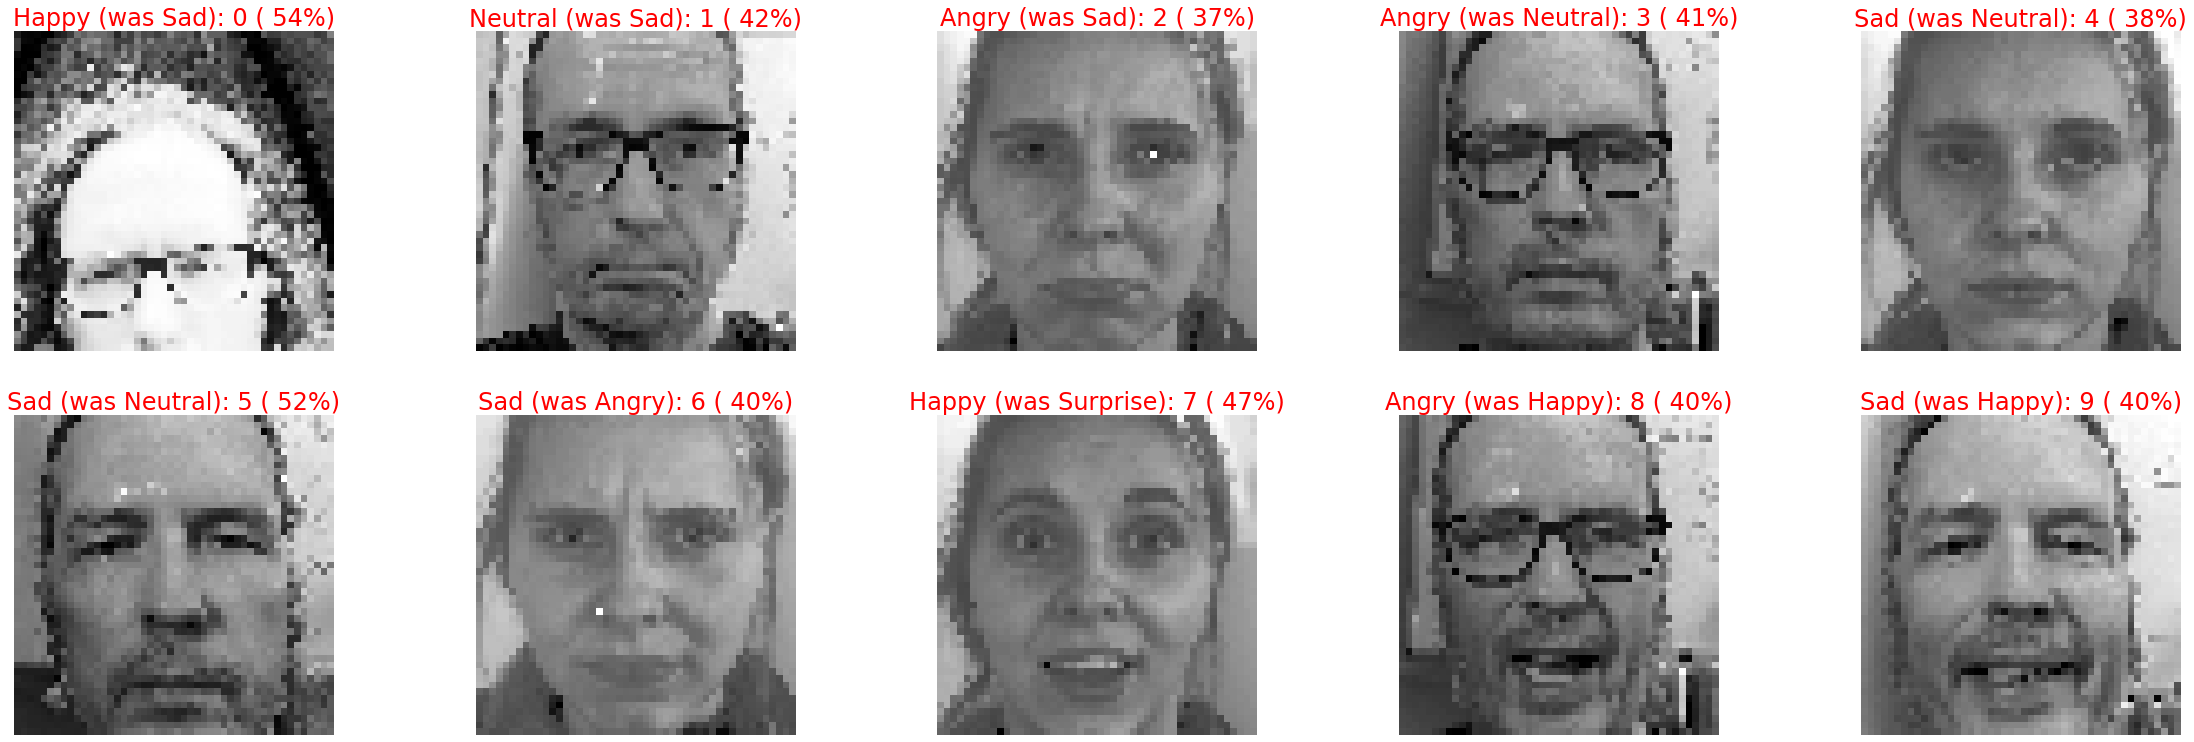

In [116]:
plot_gallery(model, X_real_world[wrong_indices], y_real_world[wrong_indices], filtered_label_names)

### Low Certainty

In [117]:
certainty = y_real_world_pred_raw.max(axis=1)
certainty

array([0.3462912 , 0.45141554, 0.5433733 , 0.6188826 , 0.4229257 ,
       0.3731253 , 0.5221009 , 0.41277632, 0.3860591 , 0.5290452 ,
       0.42427558, 0.5637707 , 0.5093641 , 0.4090556 , 0.6144353 ,
       0.6109189 , 0.46804407, 0.583061  , 0.9731486 , 0.99496293,
       0.9658907 , 0.9037224 , 0.9417611 , 0.47282106, 0.9866079 ,
       0.40243614, 0.8834595 , 0.9471306 , 0.93583536, 0.4042284 ],
      dtype=float32)

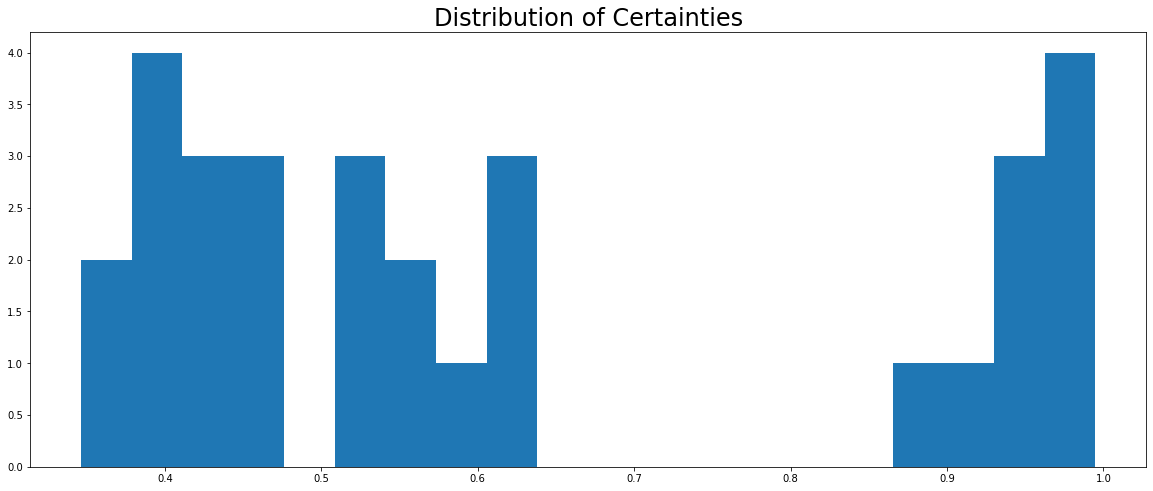

In [118]:
plt.title('Distribution of Certainties')
plt.hist(certainty, bins=20);

In [119]:
threshold = 0.7
# threshold = 0.9

In [120]:
low_certainty_indices = np.where(certainty < threshold)[0]
low_certainty_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 23, 25, 29])

(0.6188826, 0.34629145, 0.47944796)

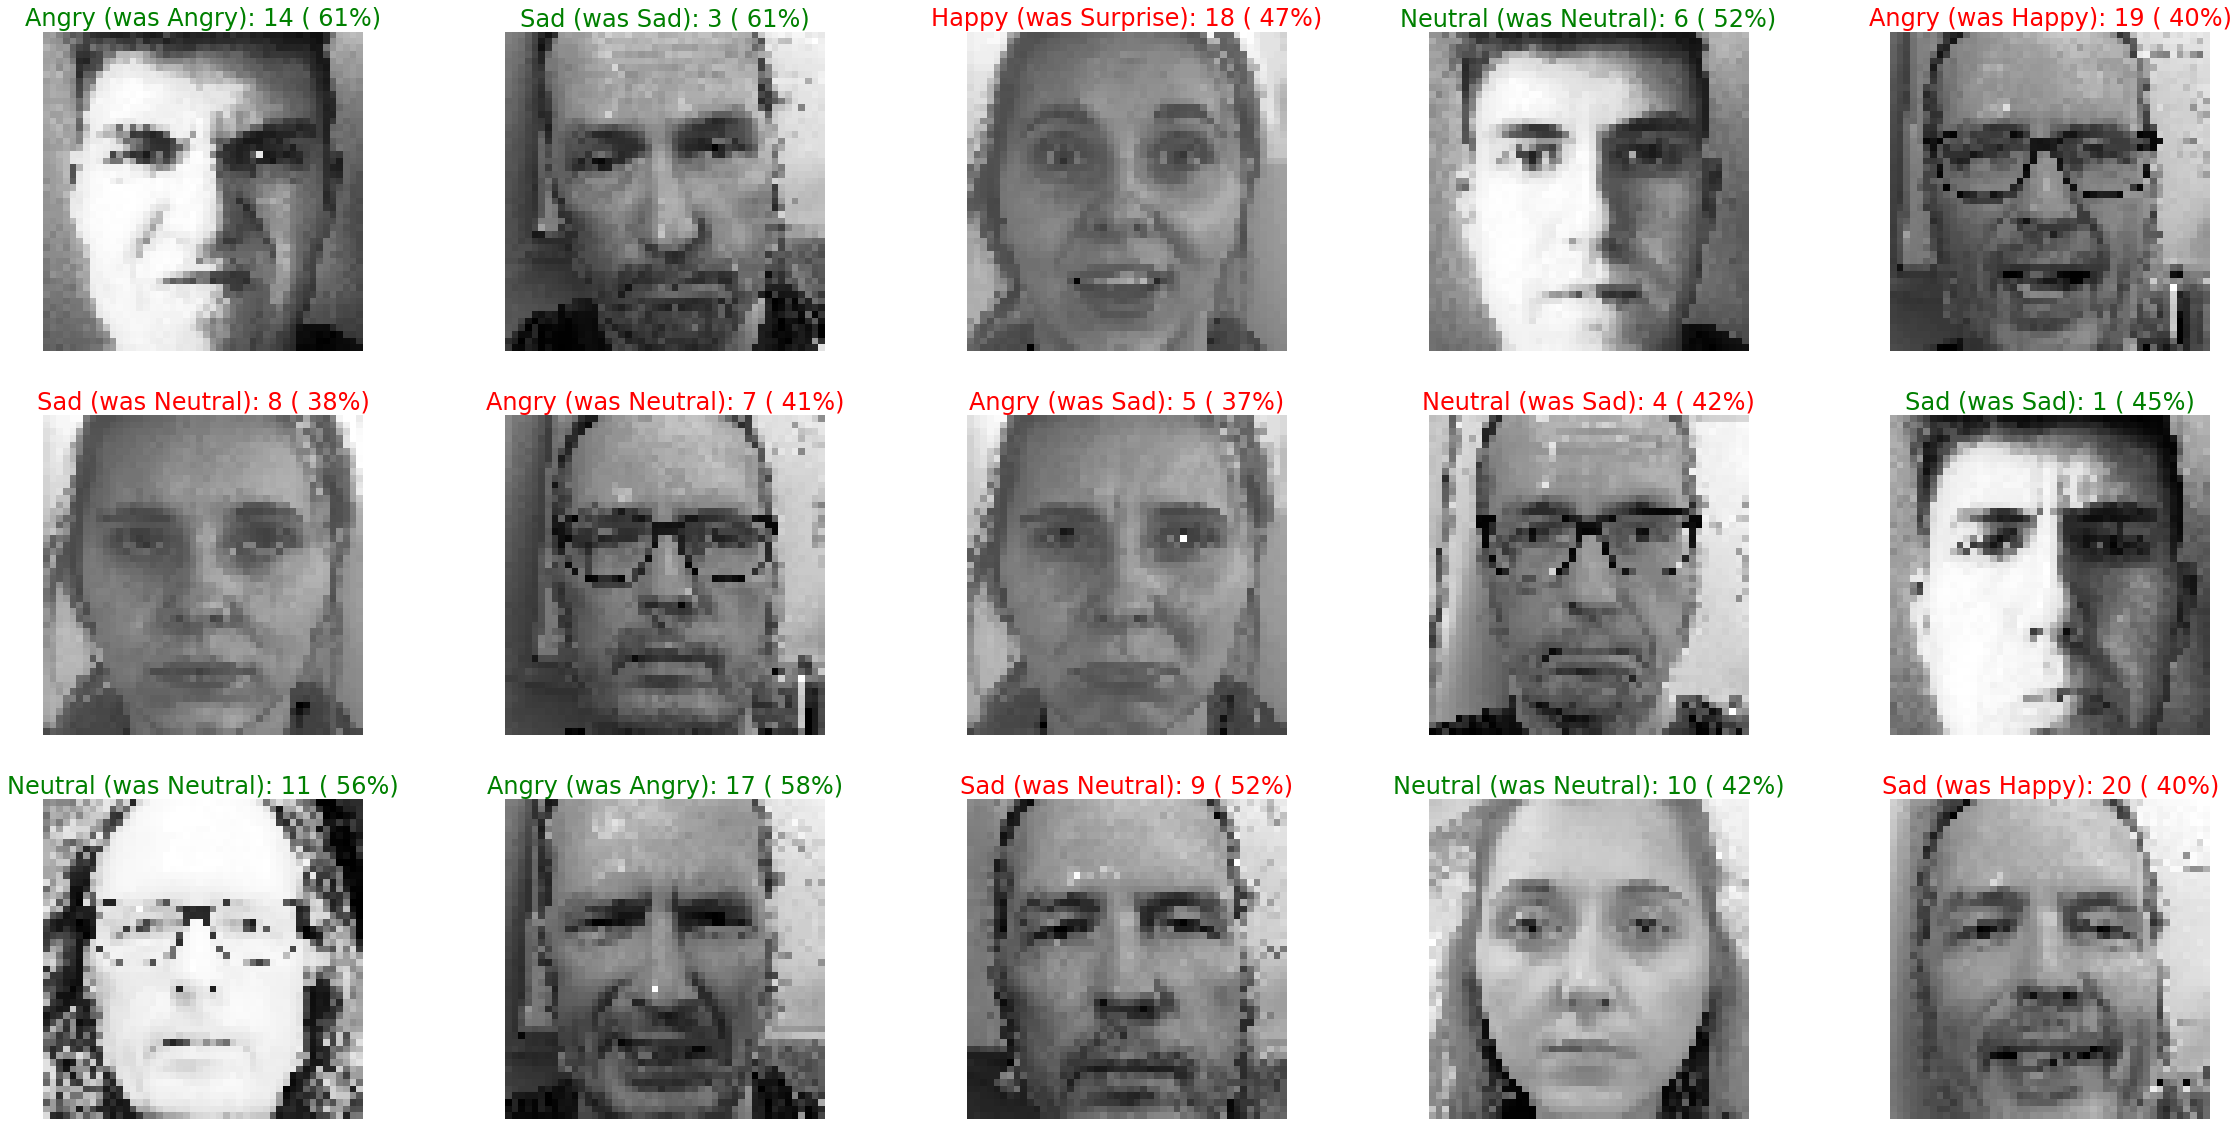

In [121]:
plot_gallery(model, X_real_world[low_certainty_indices], y_real_world[low_certainty_indices], filtered_label_names)

### High Certainty

In [122]:
# threshold = 0.80
threshold = 0.90

In [123]:
high_certainty_indices = np.where(certainty > threshold)[0]
high_certainty_indices

array([18, 19, 20, 21, 22, 24, 27, 28])

(0.99496293, 0.9037225, 0.9561325)

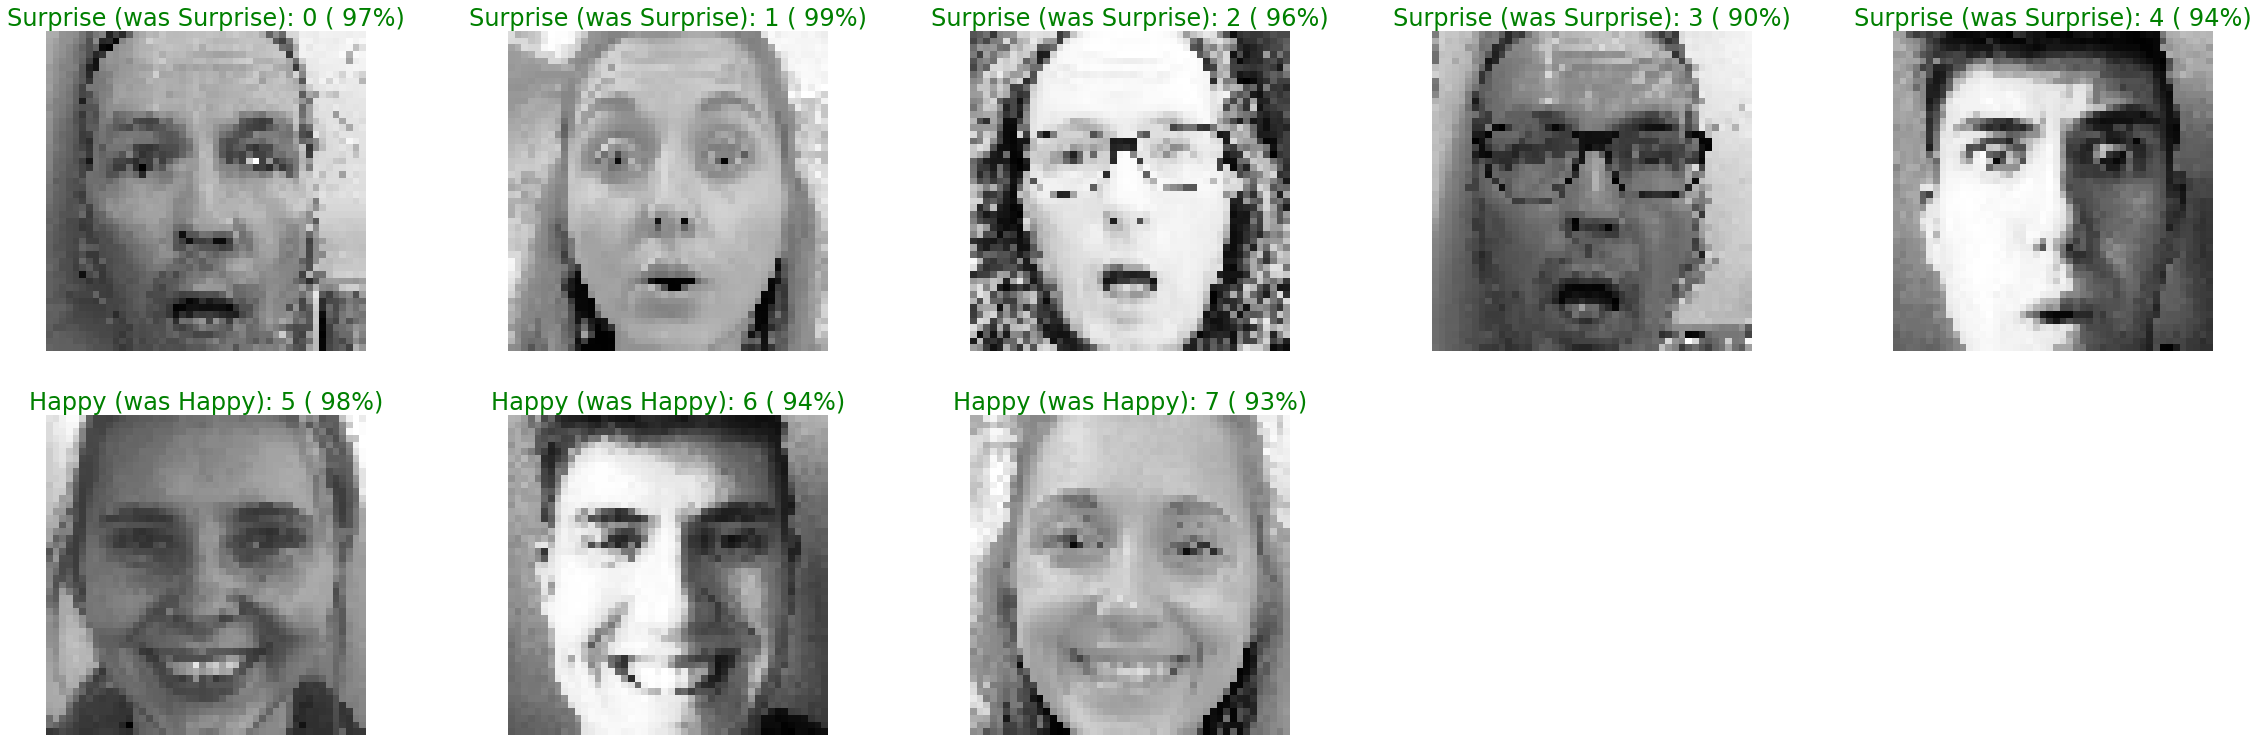

In [124]:
plot_gallery(model, X_real_world[high_certainty_indices], y_real_world[high_certainty_indices], filtered_label_names)